In [56]:
from pyspark.ml import Pipeline 

from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator 

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import HashingTF, IDF, Tokenizer 

from pyspark.ml.feature import OneHotEncoder, IndexToString, StringIndexer, VectorIndexer, VectorAssembler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark import SparkContext 

from pyspark import SQLContext 
from pyspark.ml.feature import StopWordsRemover
import pickle
import random

In [14]:
with open('filename.pickle', 'rb') as handle: 

    b = pickle.load(handle) 

In [15]:
listData = b['DF']

In [16]:
random.shuffle(listData)


In [65]:
sc.stop()

In [66]:
 

sc = SparkContext.getOrCreate() 

spark = SQLContext(sc) 

In [76]:
sentenceData = spark.createDataFrame(listData)

/home/krithika/anaconda3/lib/python3.6/site-packages/pyspark/sql/session.py:340: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


In [77]:
sentenceData = sentenceData.withColumnRenamed("label","category")
sentenceData.show()

+--------------------+--------+
|             article|category|
+--------------------+--------+
|Our guide to the ...|   Music|
|Chris Borland kno...|  Sports|
|“You have ideas a...|   Music|
|When President Tr...|Politics|
|She stared down t...|Business|
|Our guide to the ...|   Music|
|Age 34Hometown Th...|Business|
|Grindr, the socia...|   Music|
|It is a scenario ...|  Sports|
|(Reuters) - Calif...|Politics|
|The Nippon-Ham Fi...|  Sports|
|During a Grammy A...|   Music|
|Nathan Davis, a j...|   Music|
|If you love baseb...|  Sports|
|WASHINGTON —  The...|Politics|
|The NFL accused s...|  Sports|
|AUGUSTA, Ga. — Ti...|  Sports|
|BUILT The Hidden ...|Business|
|SAN ANTONIO — The...|  Sports|
|All the symbolic ...|   Music|
+--------------------+--------+
only showing top 20 rows



In [78]:
training, test = sentenceData.randomSplit([0.7, 0.3], seed=12345)

In [79]:
training.show()

+--------------------+--------+
|             article|category|
+--------------------+--------+
|(Reuters) - Calif...|Politics|
|(Want to get this...|   Music|
|A decade ago, New...|Politics|
|AUGUSTA, Ga. — Ti...|  Sports|
|All the symbolic ...|   Music|
|BRUSSELS —  The E...|Politics|
|BUILT The Hidden ...|Business|
|CHEYENNE, Wyo. — ...|Politics|
|COLORADO SPRINGS,...|  Sports|
|Chris Borland kno...|  Sports|
|DALLAS —  A Micke...|  Sports|
|Grindr, the socia...|   Music|
|HONG KONG — China...|Business|
|If you love baseb...|  Sports|
|If you’ve never h...|  Sports|
|It is a scenario ...|  Sports|
|JEFFERSON CITY, M...|Politics|
|LIMA, Peru —  Pan...|Politics|
|LONDON — William ...|   Music|
|LOS ANGELES — You...|  Sports|
+--------------------+--------+
only showing top 20 rows



In [80]:
from pyspark.sql.functions import col

sentenceData.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|  Sports|   74|
|   Music|   68|
|Politics|   45|
|Business|   31|
+--------+-----+



In [158]:
 

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr. 

tokenizer = Tokenizer(inputCol="article", outputCol="words") 

remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered")

hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features") 

label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=['Music', 'Sports', 'Politics', 'Business'])
lr = LogisticRegression(maxIter=10, family="multinomial") 

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=['Music', 'Sports', 'Politics', 'Business'])

pipeline = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx, lr,labelConverter]) 

In [137]:
# naive baiyes
nb = NaiveBayes(modelType="multinomial")
pipeline = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx, nb,labelConverter]) 

In [83]:
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label").fit(training)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(training)

In [84]:
training.show()

+--------------------+--------+
|             article|category|
+--------------------+--------+
|(Reuters) - Calif...|Politics|
|(Want to get this...|   Music|
|A decade ago, New...|Politics|
|AUGUSTA, Ga. — Ti...|  Sports|
|All the symbolic ...|   Music|
|BRUSSELS —  The E...|Politics|
|BUILT The Hidden ...|Business|
|CHEYENNE, Wyo. — ...|Politics|
|COLORADO SPRINGS,...|  Sports|
|Chris Borland kno...|  Sports|
|DALLAS —  A Micke...|  Sports|
|Grindr, the socia...|   Music|
|HONG KONG — China...|Business|
|If you love baseb...|  Sports|
|If you’ve never h...|  Sports|
|It is a scenario ...|  Sports|
|JEFFERSON CITY, M...|Politics|
|LIMA, Peru —  Pan...|Politics|
|LONDON — William ...|   Music|
|LOS ANGELES — You...|  Sports|
+--------------------+--------+
only showing top 20 rows



In [161]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures")

In [162]:
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="indexedFeatures")

In [152]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=['Music', 'Sports', 'Politics', 'Business'])

In [163]:
pipeline = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx,featureIndexer, rf,labelConverter]) 

In [175]:
# tokenizer = Tokenizer(inputCol="article", outputCol="words")
# wordsData = tokenizer.transform(training)

# hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=50)
# featurizedData = hashingTF.transform(wordsData)
# # alternatively, CountVectorizer can also be used to get term frequency vectors

# idf = IDF(inputCol="rawFeatures", outputCol="features")
# idfModel = idf.fit(featurizedData)
# rescaledData = idfModel.transform(featurizedData)

# rescaledData.select("features").show()
# featurizedData.show()

In [176]:
# hashingTF.getNumFeatures()
# hashingTF.extractParamMap()

In [168]:
# lblidx = StringIndexer(inputCol = "label", outputCol = "NumLabel")

In [67]:
# NN
layers = [4, 5, 4]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234)

pipeline = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx,featureIndexer, trainer,labelConverter]) 

In [154]:
# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. 

# This will allow us to jointly choose parameters for all Pipeline stages. 

# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator. 

# We use a ParamGridBuilder to construct a grid of parameters to search over. 

# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam, 

# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from. 

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1]) \
    .addGrid(trainer.maxIter, [10, 50, 100]) \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(rf.numTrees, [10, 50]) \
    .build()

    

In [155]:
crossval = CrossValidator(estimator=pipeline, 

                          estimatorParamMaps=paramGrid, 

                          evaluator=MulticlassClassificationEvaluator(), 

                          numFolds=3)  # use 3+ folds in practice 

 

In [164]:
# Run cross-validation, and choose the best set of parameters. 

cvModel = crossval.fit(training)

Py4JJavaError: An error occurred while calling o914033.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 18028.0 failed 1 times, most recent failure: Lost task 3.0 in stage 18028.0 (TID 67108, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$11: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: VectorIndexer encountered invalid value 11.0 on feature index 9. To handle or skip invalid value, try setting VectorIndexer.handleInvalid.
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$10.apply(VectorIndexer.scala:400)
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$10.apply(VectorIndexer.scala:356)
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$11.apply(VectorIndexer.scala:431)
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$11.apply(VectorIndexer.scala:431)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$countByKey$1.apply(PairRDDFunctions.scala:370)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$countByKey$1.apply(PairRDDFunctions.scala:370)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.countByKey(PairRDDFunctions.scala:369)
	at org.apache.spark.rdd.RDD$$anonfun$countByValue$1.apply(RDD.scala:1208)
	at org.apache.spark.rdd.RDD$$anonfun$countByValue$1.apply(RDD.scala:1208)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.countByValue(RDD.scala:1207)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:42)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:42)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:215)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:215)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:84)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$11: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: VectorIndexer encountered invalid value 11.0 on feature index 9. To handle or skip invalid value, try setting VectorIndexer.handleInvalid.
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$10.apply(VectorIndexer.scala:400)
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$10.apply(VectorIndexer.scala:356)
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$11.apply(VectorIndexer.scala:431)
	at org.apache.spark.ml.feature.VectorIndexerModel$$anonfun$11.apply(VectorIndexer.scala:431)
	... 18 more


In [99]:
 

# Make predictions on test documents. cvModel uses the best model found (lrModel). 

prediction = cvModel.transform(test) 

selected = prediction.select("category","label", "probability", "prediction","predictedLabel") 

for row in selected.collect()[:2]: 

    print(row) 
    

Row(category='Sports', label=0.0, probability=DenseVector([0.9999, 0.0, 0.0, 0.0]), prediction=0.0, predictedLabel='Music')
Row(category='Business', label=3.0, probability=DenseVector([0.0013, 0.9501, 0.02, 0.0286]), prediction=1.0, predictedLabel='Sports')


Row(category='Politics', label=2.0, probability=DenseVector([0.0, 0.0, 1.0, 0.0]), prediction=2.0)
Row(category='Politics', label=2.0, probability=DenseVector([0.0, 0.0, 1.0, 0.0]), prediction=2.0)
Row(category='Politics', label=2.0, probability=DenseVector([0.0, 0.0, 1.0, 0.0]), prediction=2.0)
Row(category='Politics', label=2.0, probability=DenseVector([0.0, 0.0, 1.0, 0.0]), prediction=2.0)
Row(category='Sports', label=1.0, probability=DenseVector([0.0, 1.0, 0.0, 0.0]), prediction=1.0)
Row(category='Music', label=0.0, probability=DenseVector([1.0, 0.0, 0.0, 0.0]), prediction=0.0)
Row(category='Politics', label=2.0, probability=DenseVector([0.0, 0.0, 1.0, 0.0]), prediction=2.0)
Row(category='Sports', label=1.0, probability=DenseVector([0.0, 1.0, 0.0, 0.0]), prediction=1.0)
Row(category='Sports', label=1.0, probability=DenseVector([0.0023, 0.9931, 0.0003, 0.0043]), prediction=1.0)
Row(category='Business', label=3.0, probability=DenseVector([0.0, 0.0, 0.0173, 0.9827]), prediction=3.0)
R

In [211]:
prediction.

DataFrame[article: string, category: string, words: array<string>, filtered: array<string>, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [31]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [117]:
prediction = cvModel.transform(test) 
predictionAndLabel = prediction.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabel)
print(metrics.confusionMatrix())
print(metrics.accuracy)
print(metrics.precision()) # precision
print(metrics.fMeasure()) #f1 score
print(metrics.recall()) # recall
print(metrics.weightedFalsePositiveRate)


DenseMatrix([[ 18.,   0.,   0.,   0.],
             [  2.,  15.,   1.,   0.],
             [  0.,   1.,  13.,   2.],
             [  0.,   2.,   1.,   8.]])
0.8571428571428571
0.8571428571428571
0.8571428571428571
0.8571428571428571
0.049268698204868414


In [109]:
import numpy as np

metrics.confusionMatrix()
metrics.confusionMatrix

<bound method MulticlassMetrics.confusionMatrix of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f78ec23e240>>

In [127]:
npLbl = np.array(prediction.select( "label").collect(),dtype=int)
npPred = np.array(prediction.select("prediction").collect(),dtype=int)

In [113]:
from sklearn.metrics import confusion_matrix

In [130]:
confusion_matrix(npLbl,npPred)

array([[18,  0,  0,  0],
       [ 2, 15,  1,  0],
       [ 0,  1, 13,  2],
       [ 0,  2,  1,  8]])

In [131]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

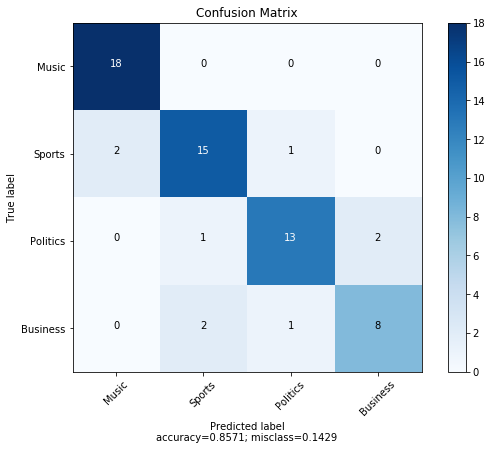

In [132]:
plot_confusion_matrix(cm           = confusion_matrix(npLbl,npPred), 
                      normalize    = False,
                      target_names = ['Music', 'Sports', 'Politics', 'Business'],
                      title        = "Confusion Matrix")

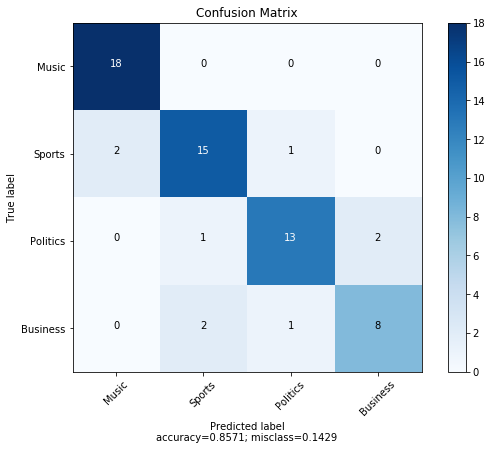

Precision : 0.8571428571428571
F-Score : 0.8571428571428571
Recall : 0.8571428571428571
Weighted False Positive Rate : 0.049268698204868414


In [135]:
# Prediction

#Logistic Regression
prediction = cvModel.transform(test) 
predictionAndLabel = prediction.select("prediction", "label").rdd
npLbl = np.array(prediction.select( "label").collect(),dtype=int)
npPred = np.array(prediction.select("prediction").collect(),dtype=int)
metrics = MulticlassMetrics(predictionAndLabel)
plot_confusion_matrix(cm           = confusion_matrix(npLbl,npPred), 
                      normalize    = False,
                      target_names = ['Music', 'Sports', 'Politics', 'Business'],
                      title        = "Confusion Matrix")
print("Precision :",metrics.precision()) # precision
print("F-Score :",metrics.fMeasure()) #f1 score
print("Recall :",metrics.recall()) # recall
print("Weighted False Positive Rate :",metrics.weightedFalsePositiveRate)